### HW5. Author Andrii Zadaianchuk

In [11]:
from __future__ import division
import scipy.io
from matplotlib import pyplot as plt
import numpy as np

In [411]:
X_train=scipy.io.loadmat('mnist_train.mat')['train']
X_test=scipy.io.loadmat('mnist_test.mat')['test']
def change_format(data):
    
    N=0
    k=0
    for i in range(10):
        N=N+data[0,i].shape[1]
        
    data_changed=np.zeros((N,28,28))
    labels=np.zeros(N)
    
    for i in range(10):
        N_i=data[0,i].shape[1]
        for j in range(N_i):
            data_changed[k+j,:,:]=data[0,i][:,j].reshape((28,28)).T
            labels[k+j]=i
        k=k+N_i
    return data_changed,labels
            
        
        
X_train,y_train=change_format(X_train)
X_test,y_test=change_format(X_test)

inds=[y_train==i for i in range(10)]
inds_test=[y_test==i for i in range(10)]

X_train_2=X_train[inds[0]|inds[9]]
y_train_2=y_train[inds[0]|inds[9]]
X_test_2=X_test[inds_test[0]|inds_test[9]]
y_test_2=y_test[inds_test[0]|inds_test[9]]

m_1=X_train[inds[0]].mean(axis=0)
m_0=X_train[inds[9]].mean(axis=0)
var_1=X_train[inds[0]].var(axis=0)
var_0=X_train[inds[9]].var(axis=0)

Average 1

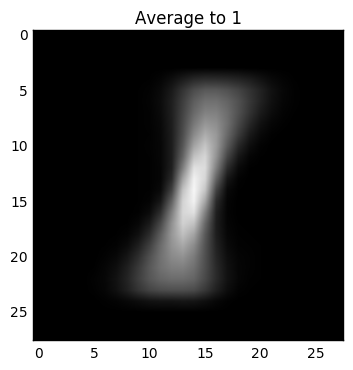

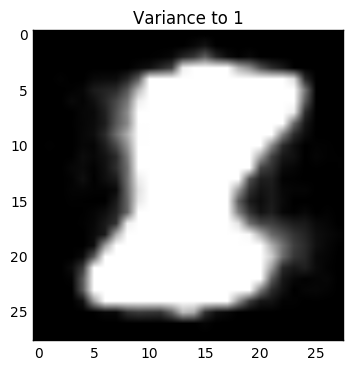

In [412]:
plt.imshow(m_1, cmap='gray', vmin = 0, vmax = 255)
plt.title("Average to 1")
plt.show()
plt.imshow(var_1, cmap='gray', vmin = 0, vmax = 255)
plt.title("Variance to 1")
plt.show()

Average 0

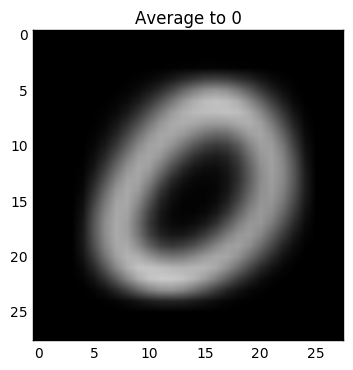

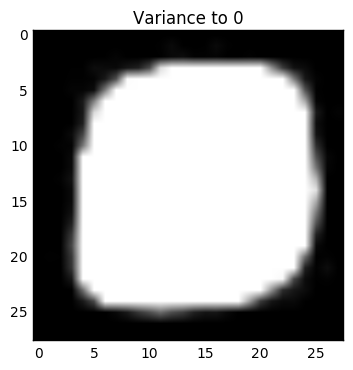

In [413]:
plt.imshow(m_0, cmap='gray', vmin = 0, vmax = 255)
plt.title("Average to 0")
plt.show()

plt.imshow(var_0, cmap='gray', vmin = 0, vmax = 255)
plt.title("Variance to 0")
plt.show()

In [414]:
X_train_2=X_train_2-X_train_2.mean(axis=0)
X_test_2=X_test_2-X_test_2.mean(axis=0)

X_train_2_flat=X_train_2.reshape(-1,28*28)
X_test_2_flat=X_test_2.reshape(-1,28*28)

def PCA(X):
    cov=np.matmul(X.T,X)/X.shape[0]
    cov2=np.cov(X.T)
    U, s, V=np.linalg.svd(cov)
    return (U,s,V)
    
(U,s,V)=PCA(X_train_2_flat)

def get_number_of_components(percent,s):
    for i,x in enumerate(s.cumsum()/s.sum()):
        if x>percent:
            return i,x 
        
m=get_number_of_components(0.9,s)[0]

print "Number of components to explain 90% of variance:",m

def get_error(m,U): 
    U_m=U[:,:m]
    reconstraction_error=((X_train_2_flat-np.matmul(np.matmul(X_train_2_flat,U_m),U_m.T))**2).sum()/(X_train_2_flat**2).sum()
    return reconstraction_error

    print "Reconstraction error:", get_error(m,U)

print "Explained varivance for 2 components:", s.cumsum()[1]/s.sum(),"Reconstraction error for two components:", get_error(2,U)


Number of components to explain 90% of variance: 48
Explained varivance for 2 components: 0.411405600656 Reconstraction error for two components: 0.588594399344


In [442]:
Z=np.matmul(X_train_2_flat, U[:,:2])
Z_test=np.matmul(X_test_2_flat, U[:,:2])
y=y_train_2

In [443]:
def estimate_parameters(Z,y):
    m0=Z[y==0].mean(axis=0)
    m1=Z[y==9].mean(axis=0)
    cov0=np.cov(Z[y==0].T)
    cov1=np.cov(Z[y==9].T)
    return (m0,cov0,m1,cov1)

def loglikelihood(x,params):
    m=params[0]
    cov=params[1]
    loglikel = -(1/2)*np.matmul(np.matmul((x-m).T,np.linalg.inv(cov)),x-m)
    loglikel += -(1/2)*np.log(np.linalg.det(cov))
    return loglikel


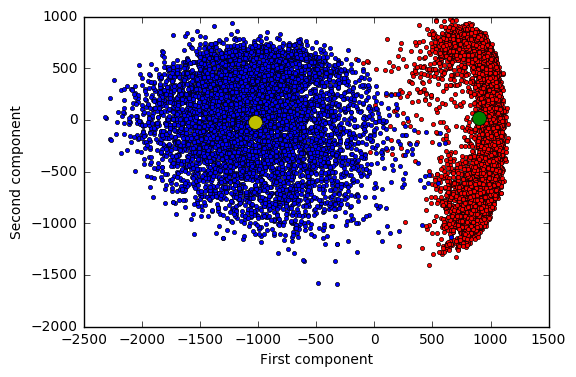

In [444]:
plt.plot(Z[y==0][:,0],Z[y==0][:,1],'ro', markersize=3)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.plot(Z[y==9][:,0],Z[y==9][:,1],'bo',markersize=3)
m0,cov0,m1,cov1=estimate_parameters(Z,y)
plt.plot(m0[0],m0[1],'go',markersize=10)
plt.plot(m1[0],m1[1],'yo',markersize=10)
plt.show()

In [445]:
clasify=lambda x: loglikelihood(x,[m1,cov1]) - loglikelihood(x,[m0,cov0]) 
x1=np.linspace(-2500,1500,200)
x2=np.linspace(-2000,1000,200)
X1,X2=np.meshgrid(x1,x2)
Z_all=np.dstack(np.meshgrid(x1,x2)).reshape(-1, 2)
score=np.apply_along_axis(clasify,1,Z_all)

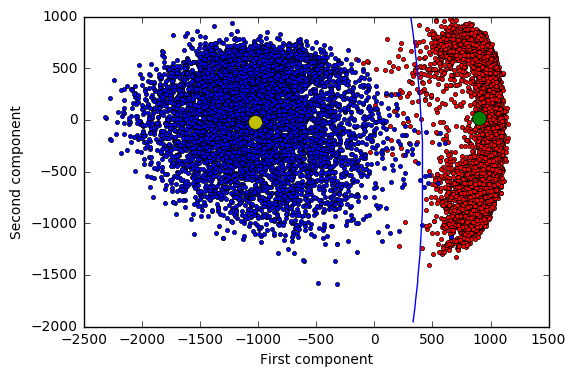

In [446]:
plt.plot(Z[y==0][:,0],Z[y==0][:,1],'ro', markersize=3)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.plot(Z[y==9][:,0],Z[y==9][:,1],'bo',markersize=3)
plt.plot(m0[0],m0[1],'go',markersize=10)
plt.plot(m1[0],m1[1],'yo',markersize=10)
plt.plot(X1[np.abs(score.reshape((200,200)))<0.05],X2[np.abs(score.reshape((200,200)))<0.05])
plt.show()
y_pred=np.apply_along_axis(clasify,1,Z)<0
y_test_pred=np.apply_along_axis(clasify,1,Z_test)<0

In [447]:
accuracy=((y_pred)==(y==0)).mean(),((y_test_pred)==(y_test_2==0)).mean()
print "train 0-1 loss", accuracy[0], "test 0-1 loss", accuracy[1]

train 0-1 loss 0.993841294907 test 0-1 loss 0.99621749409


### d) e)

In [450]:
def train_lin(Z,y):
    N=Z.shape[0]
    c=(y==0).astype(int)
    Z=Z.T
    
    cxx=(1/N)*np.matmul(Z,Z.T)
    cyx=(1/N)*np.matmul(c,Z.T)
    w=np.matmul(cyx,np.linalg.inv(cxx))

    # optimal v grid search
    v=np.linspace(-5,1,1000)[np.argmax([((np.matmul(w,Z)-(x)>0)==(y==0)).mean() for x in np.linspace(-5,1,1000)])]

    return (w,v)

#### Linear case

In [448]:
w,v=train_lin(Z,y)
accuracy_lin=((np.matmul(Z,w)>v)==(y==0)).mean(), ((np.matmul(Z_test,w)>v)==(y_test_2==0)).mean()
print "train 0-1 loss", accuracy_lin[0], "test 0-1 loss", accuracy_lin[1]



train 0-1 loss 0.995657323332 test 0-1 loss 0.996690307329


#### Additional features

In [449]:
def quad_features(Z):
    z01=Z[:,0]*Z[:,1]
    z01=np.expand_dims(z01,axis=1)
    z00=Z[:,0]*Z[:,0]
    z00=np.expand_dims(z00,axis=1)
    z11=Z[:,1]*Z[:,1]
    z11=np.expand_dims(z11,axis=1)
    return np.concatenate((Z,z00,z01,z11), axis=1)

Z_2=quad_features(Z)
Z_test_2=quad_features(Z_test)
w_2,v_2=train_lin(Z_2, y)
accuracy_lin=((np.matmul(Z_2,w_2)-v_2>0)==(y==0)).mean(), ((np.matmul(Z_test_2,w_2)-v_2>0)==(y_test_2==0)).mean()
print "train 0-1 loss", accuracy_lin[0], "test 0-1 loss", accuracy_lin[1]


train 0-1 loss 0.989893407027 test 0-1 loss 0.991489361702


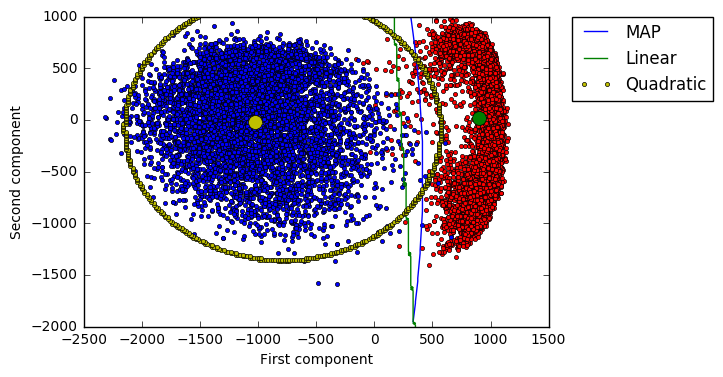

In [472]:
score2=(np.matmul(Z_all,w)-v)
score3=(np.matmul(quad_features(Z_all),w_2)-v_2)
plt.plot(Z[y==0][:,0],Z[y==0][:,1],'ro', markersize=3)
plt.xlabel("First component")
plt.ylabel("Second component")
plt.plot(Z[y==9][:,0],Z[y==9][:,1],'bo',markersize=3)
plt.plot(m0[0],m0[1],'go',markersize=10)
plt.plot(m1[0],m1[1],'yo',markersize=10)
plt.plot(X1[np.abs(score.reshape((200,200)))<0.05],X2[np.abs(score.reshape((200,200)))<0.05],label='MAP')
plt.plot(X1[np.abs(score2.reshape((200,200)))<0.005],X2[np.abs(score2.reshape((200,200)))<0.005], label='Linear')
plt.plot(X1[np.abs(score3.reshape((200,200)))<0.01],X2[np.abs(score3.reshape((200,200)))<0.01],'yo',markersize=3, label='Quadratic')

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()
plt.show()
